# Imports

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer 
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score

In [3]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import F1Score

from dgl.nn.pytorch import GraphConv, SAGEConv
from ray import tune

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Starting with the gene data

Building the graph and getting gene names, ids and if they are pathogenic or not.

In [5]:
df_brown=pd.read_csv("Data\Brown\df_brown_module.csv")

In [6]:
df_brown # non-pathogenic column : 1-pathogenic, 0=nonpathogenic, unlabelled

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
0,SEMA3F,brown,30.545872,9.132398,21.413474,-12.281076,False,0.477729,0.374054,False,False,1,0.176808,False,False,unlabelled
1,LAP3,brown,142.383024,33.368181,109.014843,-75.646662,False,-0.695294,0.052100,True,True,1,0.178580,False,False,unlabelled
2,SLC25A5,brown,850.931187,131.143994,719.787194,-588.643200,False,-0.875225,0.000036,True,True,1,0.211125,False,False,unlabelled
3,HOXA11,brown,27.467057,6.850781,20.616276,-13.765495,False,0.317136,0.774170,False,False,1,0.158539,False,False,unlabelled
4,THSD7A,brown,14.881489,3.201778,11.679711,-8.477933,False,-0.198328,0.936240,False,False,1,0.170051,False,False,unlabelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388,AL590763.16,brown,30.309564,7.524000,22.785564,-15.261564,False,-0.360671,0.724569,False,False,1,0.171284,False,False,unlabelled
2389,AC011380.8,brown,36.187984,10.765991,25.421993,-14.656003,False,0.416717,0.288265,False,False,1,0.192600,False,False,unlabelled
2390,KB-1995A5.5,brown,15.120943,3.229709,11.891234,-8.661525,False,-0.213702,0.651769,False,False,1,0.182217,False,False,unlabelled
2391,LLNLR-263F3.1,brown,44.107141,12.301400,31.805741,-19.504340,False,0.409929,0.143333,False,False,1,0.183687,False,False,unlabelled


In [7]:
df_brown['pathogenic'].value_counts()

unlabelled    2314
1               49
0               30
Name: pathogenic, dtype: int64

In [8]:
df_brown[df_brown['GeneName']=='VPS13D']   

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
62,VPS13D,brown,173.374856,47.746258,125.628599,-77.882341,False,0.198,0.860961,True,False,1,0.183256,False,False,unlabelled


In [9]:
df_brown[df_brown['GeneName']=='UFM1']   

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
496,UFM1,brown,961.730605,88.004791,873.725814,-785.721023,False,-0.799434,0.000379,False,False,1,0.173211,False,False,unlabelled


In [10]:
df_brown[df_brown['GeneName']=='C1QBP']

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
335,C1QBP,brown,335.23418,120.823574,214.410606,-93.587032,False,-0.951085,0.016234,True,False,1,0.194612,False,True,unlabelled


In [11]:
df_brown.dtypes

GeneName                         object
module_name                      object
kTotal                          float64
kWithin                         float64
kOut                            float64
kDiff                           float64
is.hub                             bool
ME                              float64
MM                              float64
Mitocarta                          bool
Interactome                        bool
in_enriched_module_mitocarta      int64
cor_with_gtex                   float64
gtex                               bool
in_md_list                         bool
pathogenic                       object
dtype: object

In [12]:
df_brown[df_brown.isnull().any(axis=1)]

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic


In [13]:
df_brown[df_brown['GeneName']=='GPHN']

,GeneName,module_name,kTotal,kWithin,kOut,kDiff,is.hub,ME,MM,Mitocarta,Interactome,in_enriched_module_mitocarta,cor_with_gtex,gtex,in_md_list,pathogenic
1265,GPHN,brown,368.002266,50.976209,317.026057,-266.049848,False,-0.730578,0.002604,False,False,1,0.199473,False,False,unlabelled


Important genes<br>
ADCY5, blue <br>
UFM1,VPS13D brown

## Working with BROWN module

In [14]:
# the data that tells us if a gene is pathogenic or not
gene_data = df_brown[['GeneName','pathogenic']]
gene_data

,GeneName,pathogenic
0,SEMA3F,unlabelled
1,LAP3,unlabelled
2,SLC25A5,unlabelled
3,HOXA11,unlabelled
4,THSD7A,unlabelled
...,...,...
2388,AL590763.16,unlabelled
2389,AC011380.8,unlabelled
2390,KB-1995A5.5,unlabelled
2391,LLNLR-263F3.1,unlabelled


### keeping nodes in brown module that has connection in co-expression data  (co-expression network part)

In [15]:
df_co_expression_in=pd.read_csv("Data/Brown/co_expression_brown.csv")
df_co_expression_in

,fromNode,toNode,weight,direction,fromAltName,toAltName
0,SEMA3F,SLC25A5,0.153358,undirected,NaN,NaN
1,SEMA3F,TNFRSF12A,0.126315,undirected,NaN,NaN
2,SEMA3F,ZNF207,0.126750,undirected,NaN,NaN
3,SEMA3F,TSPAN9,0.106554,undirected,NaN,NaN
4,SEMA3F,PPP5C,0.129404,undirected,NaN,NaN
...,...,...,...,...,...,...
592765,LA16c-380F5.3,CH17-172B3.1,0.143480,undirected,NaN,NaN
592766,ERICD,CH17-172B3.1,0.138248,undirected,NaN,NaN
592767,ERICD,LLNLR-263F3.1,0.112343,undirected,NaN,NaN
592768,RP4-568B10.1,RP11-121P12.1,0.107567,undirected,NaN,NaN


In [16]:
df_co_expression_in[((df_co_expression_in['fromNode']=='VPS13D') | (df_co_expression_in['toNode']=='VPS13D')) & 
                 (df_co_expression_in['weight']>0.2)]

,fromNode,toNode,weight,direction,fromAltName,toAltName
870,SLC25A5,VPS13D,0.256056,undirected,NaN,NaN
3429,TNFRSF12A,VPS13D,0.255352,undirected,NaN,NaN
14611,PPP5C,VPS13D,0.253559,undirected,NaN,NaN
19431,MNAT1,VPS13D,0.260600,undirected,NaN,NaN
22676,PHF20,VPS13D,0.259211,undirected,NaN,NaN
...,...,...,...,...,...,...
34103,VPS13D,MRPL33,0.203170,undirected,NaN,NaN
34130,VPS13D,AGAP2-AS1,0.208497,undirected,NaN,NaN
34133,VPS13D,KIAA1147,0.232406,undirected,NaN,NaN
34164,VPS13D,ZNF528-AS1,0.214764,undirected,NaN,NaN


In [17]:
df_co_expression=df_co_expression_in[df_co_expression_in['weight']>=0.2]
df_co_expression

,fromNode,toNode,weight,direction,fromAltName,toAltName
299,LAP3,SLC25A5,0.269038,undirected,NaN,NaN
300,LAP3,TNFRSF12A,0.293349,undirected,NaN,NaN
302,LAP3,ZNF207,0.210761,undirected,NaN,NaN
304,LAP3,PPP5C,0.287966,undirected,NaN,NaN
305,LAP3,MNAT1,0.279223,undirected,NaN,NaN
...,...,...,...,...,...,...
592583,RP11-397O8.7,RP4-614O4.13,0.246172,undirected,NaN,NaN
592594,RP11-397O8.7,RP11-466A19.7,0.204613,undirected,NaN,NaN
592599,RP11-397O8.7,CTC-463A16.1,0.241932,undirected,NaN,NaN
592606,RP11-397O8.7,ERICD,0.208953,undirected,NaN,NaN


In [18]:
l1=list(set(df_co_expression['fromNode']))
l1.extend(list(set(df_co_expression['toNode'])))
l1=list(set(l1))
len(l1)

1293

In [19]:
max(df_co_expression_in['weight'])

0.385189159772286

In [20]:
df_co_expression

,fromNode,toNode,weight,direction,fromAltName,toAltName
299,LAP3,SLC25A5,0.269038,undirected,NaN,NaN
300,LAP3,TNFRSF12A,0.293349,undirected,NaN,NaN
302,LAP3,ZNF207,0.210761,undirected,NaN,NaN
304,LAP3,PPP5C,0.287966,undirected,NaN,NaN
305,LAP3,MNAT1,0.279223,undirected,NaN,NaN
...,...,...,...,...,...,...
592583,RP11-397O8.7,RP4-614O4.13,0.246172,undirected,NaN,NaN
592594,RP11-397O8.7,RP11-466A19.7,0.204613,undirected,NaN,NaN
592599,RP11-397O8.7,CTC-463A16.1,0.241932,undirected,NaN,NaN
592606,RP11-397O8.7,ERICD,0.208953,undirected,NaN,NaN


In [21]:
links_co_df=pd.DataFrame()
links_co_df[['gene1','gene2','score']]=df_co_expression[['fromNode','toNode','weight']]
links_co_df

,gene1,gene2,score
299,LAP3,SLC25A5,0.269038
300,LAP3,TNFRSF12A,0.293349
302,LAP3,ZNF207,0.210761
304,LAP3,PPP5C,0.287966
305,LAP3,MNAT1,0.279223
...,...,...,...
592583,RP11-397O8.7,RP4-614O4.13,0.246172
592594,RP11-397O8.7,RP11-466A19.7,0.204613
592599,RP11-397O8.7,CTC-463A16.1,0.241932
592606,RP11-397O8.7,ERICD,0.208953


In [22]:
G_co = nx.Graph()
G_co.add_nodes_from([]) # number of nodes added = number of unique genes in links df that is added below.
G_co.add_edges_from(np.asarray(links_co_df[['gene1','gene2']]))
nodes_ss_co=list(G_co.nodes)
len(nodes_ss_co)

1293

In [23]:
links_co_df[(links_co_df['gene1']=='UFM1')|(links_co_df['gene2']=='UFM1')].sort_values('score',ascending=False).head(20)

,gene1,gene2,score
67117,MLH1,UFM1,0.374400
267101,UFM1,CCT5,0.366719
265130,TCP1,UFM1,0.352935
266853,UFM1,HAT1,0.348232
267528,UFM1,MROH1,0.338952
267047,UFM1,ATG3,0.336236
267671,UFM1,PSMD12,0.335253
267504,UFM1,PDDC1,0.334875
209494,FGFR1OP2,UFM1,0.333688
267253,UFM1,GMPS,0.333266


In [24]:
gene_links_r1=pd.DataFrame(columns=['gene1','gene2','score'])
for node in list(G_co.nodes):
    add_links=links_co_df[(links_co_df['gene1']==node)|(links_co_df['gene2']==node)].sort_values('score',ascending=False).head(20)
    gene_links_r1=gene_links_r1.append(add_links,ignore_index=True)

In [25]:
gene_links_r1.drop_duplicates(inplace=True)
gene_links_r1.reset_index(drop=True,inplace=True)
gene_links_r1

,gene1,gene2,score
0,LAP3,MLH1,0.347374
1,LAP3,CCT5,0.339664
2,LAP3,HAT1,0.327049
3,LAP3,ZKSCAN1,0.318611
4,LAP3,PSMD12,0.318186
...,...,...,...
22701,HNRNPF,PCBP2,0.200479
22702,AC007318.5,RP11-665C16.9,0.200053
22703,SCAI,PSMD12,0.207171
22704,UBE2N,CTD-3220F14.3,0.201143


In [26]:
G_co.number_of_edges()

112823

In [27]:
if 'VPS13D'in nodes_ss_co:
    print('yes')

yes


In [28]:
# filter the genes and keep only the genes that are in the graph
gene_data_ss_co = gene_data[gene_data['GeneName'].isin(nodes_ss_co)]
gene_data_ss_co

,GeneName,pathogenic
1,LAP3,unlabelled
2,SLC25A5,unlabelled
5,ACSM3,unlabelled
7,TNFRSF12A,unlabelled
9,ALDH3B1,unlabelled
...,...,...
2374,LA16c-380F5.3,unlabelled
2375,ERICD,unlabelled
2379,CH17-172B3.1,unlabelled
2391,LLNLR-263F3.1,unlabelled


In [29]:
gene_data_ss_co['pathogenic'].value_counts()

unlabelled    1239
1               37
0               17
Name: pathogenic, dtype: int64

## Transcriptomics

In [30]:
transcriptomics=pd.read_csv('Data\Transcriptomic_data_all_color.csv')
transcriptomics

,GeneName,X10.CR.RNA,X11.WTS.RNA,X12.EA.RNA,X13.CL.RNA,X14.KD.RNA,X15.SJ.RNA,X16.HZ.RNA,X17.CE.RNA,X18.RL.RNA,...,X1.VT.RNA,X20.MCC.RNA,X2.LN.RNA,X3.AS.RNA,X4.TL.RNA,X5.BE.RNA,X6.HA.RNA,X7.HH.RNA,X8.CN.RNA,X9.GC.RNA
0,DDX11L1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,4,0,0
1,WASH7P,34,34,26,15,42,39,27,47,26,...,26,19,36,39,44,28,42,56,79,34
2,MIR6859-1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,MIR1302-2HG,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RP11-34P13.7,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39197,U4,0,0,1,0,0,0,0,4,0,...,0,0,4,2,1,1,1,1,0,0
39198,U6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,0
39199,U8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39200,uc_338,2,1,3,1,2,1,0,0,6,...,1,7,1,1,2,5,3,0,2,0


### For co-expression part

In [31]:
all_data_co = pd.merge(gene_data_ss_co, transcriptomics, left_on="GeneName", right_on="GeneName", how="inner")
all_data_co

,GeneName,pathogenic,X10.CR.RNA,X11.WTS.RNA,X12.EA.RNA,X13.CL.RNA,X14.KD.RNA,X15.SJ.RNA,X16.HZ.RNA,X17.CE.RNA,...,X1.VT.RNA,X20.MCC.RNA,X2.LN.RNA,X3.AS.RNA,X4.TL.RNA,X5.BE.RNA,X6.HA.RNA,X7.HH.RNA,X8.CN.RNA,X9.GC.RNA
0,LAP3,unlabelled,1134,2889,2271,2822,2704,2568,2695,2785,...,3642,2072,3616,4312,2066,1041,3097,2771,3050,2987
1,SLC25A5,unlabelled,2211,10549,5953,6986,6538,7372,7031,7529,...,10386,5789,11715,9465,4137,2373,6622,5030,8546,8686
2,ACSM3,unlabelled,0,9,2,12,2,3,5,4,...,10,2,6,3,2,2,2,7,3,9
3,TNFRSF12A,unlabelled,2769,15056,9997,15752,10103,9256,12292,11953,...,17846,8865,17608,18060,5999,4271,10945,8350,12695,11694
4,ALDH3B1,unlabelled,1609,2542,4075,3282,2918,2785,3304,4978,...,1670,3502,3644,5492,3416,2507,3398,4843,2749,2090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,LA16c-380F5.3,unlabelled,28,9,24,12,30,14,8,23,...,20,23,11,31,8,16,16,24,19,13
1289,ERICD,unlabelled,136,88,156,143,308,151,105,170,...,93,170,79,174,145,74,232,151,78,127
1290,CH17-172B3.1,unlabelled,35,29,52,54,29,24,34,82,...,13,66,14,44,31,61,25,58,44,20
1291,LLNLR-263F3.1,unlabelled,9,13,17,12,17,21,13,18,...,9,10,17,35,16,8,18,17,8,2


In [32]:
all_data_tr_weights_co=all_data_co.drop('pathogenic',axis=1)
all_data_tr_weights_co

,GeneName,X10.CR.RNA,X11.WTS.RNA,X12.EA.RNA,X13.CL.RNA,X14.KD.RNA,X15.SJ.RNA,X16.HZ.RNA,X17.CE.RNA,X18.RL.RNA,...,X1.VT.RNA,X20.MCC.RNA,X2.LN.RNA,X3.AS.RNA,X4.TL.RNA,X5.BE.RNA,X6.HA.RNA,X7.HH.RNA,X8.CN.RNA,X9.GC.RNA
0,LAP3,1134,2889,2271,2822,2704,2568,2695,2785,1804,...,3642,2072,3616,4312,2066,1041,3097,2771,3050,2987
1,SLC25A5,2211,10549,5953,6986,6538,7372,7031,7529,2712,...,10386,5789,11715,9465,4137,2373,6622,5030,8546,8686
2,ACSM3,0,9,2,12,2,3,5,4,3,...,10,2,6,3,2,2,2,7,3,9
3,TNFRSF12A,2769,15056,9997,15752,10103,9256,12292,11953,4918,...,17846,8865,17608,18060,5999,4271,10945,8350,12695,11694
4,ALDH3B1,1609,2542,4075,3282,2918,2785,3304,4978,2645,...,1670,3502,3644,5492,3416,2507,3398,4843,2749,2090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,LA16c-380F5.3,28,9,24,12,30,14,8,23,12,...,20,23,11,31,8,16,16,24,19,13
1289,ERICD,136,88,156,143,308,151,105,170,143,...,93,170,79,174,145,74,232,151,78,127
1290,CH17-172B3.1,35,29,52,54,29,24,34,82,66,...,13,66,14,44,31,61,25,58,44,20
1291,LLNLR-263F3.1,9,13,17,12,17,21,13,18,19,...,9,10,17,35,16,8,18,17,8,2


In [33]:
# scale and transform proteomics and transcriptomics separately before merging
scaler = MinMaxScaler()
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

all_data_co.iloc[:, 2:] = scaler.fit_transform(transformer.fit_transform(all_data_co.iloc[:, 2:]))


## Creating the final graph with 2240 genes for co-expression part

In [34]:
# we create one graph for each "weights analysis": The none, CCA, PLS, and pearson analyses
G_co = nx.subgraph(G_co, all_data_co["GeneName"])

In [35]:
# The nodes need to be labelled numerically for the DGL library, so we do this
relabel_nodes_co = dict((v,k) for k,v in all_data_co.iloc[:,0].to_dict().items())

In [36]:
G_co = nx.relabel_nodes(G_co, relabel_nodes_co, copy=True)

In [37]:
len(G_co.nodes)

1293

In [38]:
all_data_co['pathogenic'].value_counts()

unlabelled    1239
1               37
0               17
Name: pathogenic, dtype: int64

# Adding weights

In [39]:
def checkIfNull(df):
    cols=[]
    for i in df.columns:
        if df[i].isnull().any():
            cols.append(i)
        else:
            continue
    if not cols:
        print("No missing values")
    else:
        print(cols)
checkIfNull(all_data_co)

No missing values


MinMaxScaler is a scaling technique that scales the values of a feature to a fixed range, typically between 0 and 1

QuantileTransformer, on the other hand, is a non-linear transformation technique that maps the data to a uniform or normal distribution

Another difference between the two is that MinMaxScaler is a parametric method that requires knowledge of the range of the data, while QuantileTransformer is a non-parametric method that does not make any assumptions about the distribution of the data.

One common use case is when the distribution of the data is not uniform and has a significant number of outliers. In this case, using MinMaxScaler alone can result in a poor scaling of the data, as it is sensitive to outliers. To address this issue, QuantileTransformer can be used to first map the data to a uniform or normal distribution before applying MinMaxScaler to scale the data to a fixed range.

Another use case is when the data has a complex, non-linear relationship between the features and the target variable. In this case, using QuantileTransformer to map the data to a uniform or normal distribution can help to capture these non-linear relationships more effectively. After mapping the data, MinMaxScaler can be used to scale the data to a fixed range.

In summary, using both MinMaxScaler and QuantileTransformer together can help to address issues related to non-uniform data distributions and outliers, as well as capture complex non-linear relationships between the features and the target variable.

In [40]:
def get_graph_weights(graph_genes, neg_weights,data):
    # keep only the genes that is in the final data
    graph_genes_ = graph_genes[graph_genes['node1'].isin(data['GeneName'])]
    graph_genes_ = graph_genes_[graph_genes_["node2"].isin(data['GeneName'])]
    if neg_weights == False:
        graph_genes_["weight"] = np.abs(graph_genes_["weight"])
    return(graph_genes_)

In [41]:
def map_node_names_to_numeric(graph_genes_,data):
    # map node names to numerical node numbers for DGL
    graph_genes_['n1'] = graph_genes_['node1'].map(lambda x: data.set_index('GeneName').index.get_loc(x))
    graph_genes_['n2'] = graph_genes_['node2'].map(lambda x: data.set_index('GeneName').index.get_loc(x))
    return(graph_genes_)

In [42]:
def get_valid_edges(graph_genes, G_, data, neg_weights):
    
    graph_genes_ = get_graph_weights(graph_genes, neg_weights,data)
    graph_genes_ = map_node_names_to_numeric(graph_genes_,data) # takes a while
    #display(graph_genes_)
    
    # create a dict with a tuple of the interacting genes as the key and the weight as value - this is the format needed to add
    # it to the graph
    genes_dict = graph_genes_.iloc[:,2:].set_index(["n1", "n2"]).to_dict(orient='index') #to_dict(orient='index') -> convert the DataFrame to a dictionary with a nested structure
    
    nx.set_edge_attributes(G_, genes_dict, "name")
    # only the edges that exist in the graph now have a weight, so we need to extract these "valid" edges
    
    valid_edges = nx.get_edge_attributes(G_, "name")
    # create df of valid edges
    valid_analysis_edges = pd.DataFrame.from_dict(valid_edges).T.reset_index()
    valid_analysis_edges = valid_analysis_edges.rename({'level_0': 'node1', "level_1":"node2"}, axis=1)
    return(valid_analysis_edges)

## Co-expression part

Here, we already have the weight obtained from co-expression dataset that is obtained with the help of Biweight mid correlation

In [43]:
co_graph_genes=pd.DataFrame()
co_graph_genes[['node1','node2','weight']]=df_co_expression[['fromNode','toNode','weight']]
co_graph_genes

,node1,node2,weight
299,LAP3,SLC25A5,0.269038
300,LAP3,TNFRSF12A,0.293349
302,LAP3,ZNF207,0.210761
304,LAP3,PPP5C,0.287966
305,LAP3,MNAT1,0.279223
...,...,...,...
592583,RP11-397O8.7,RP4-614O4.13,0.246172
592594,RP11-397O8.7,RP11-466A19.7,0.204613
592599,RP11-397O8.7,CTC-463A16.1,0.241932
592606,RP11-397O8.7,ERICD,0.208953


In [44]:
valid_CE_edges=get_valid_edges(co_graph_genes, G_co, all_data_co, neg_weights=True)
valid_CE_edges

,node1,node2,weight
0,0,1,0.269038
1,0,3,0.293349
2,0,11,0.210761
3,0,16,0.287966
4,0,21,0.279223
...,...,...,...
112818,1259,1271,0.246172
112819,1259,1279,0.204613
112820,1259,1284,0.241932
112821,1259,1289,0.208953


# Building the DGL graphs

The purpose of converting a NetworkX graph object to a DGL graph object is to be able to apply deep learning methods to the graph data. NetworkX graph object can be used in GCN, but NetworkX is not specifically designed for deep learning on graphs. 

In [45]:
def build_dgl_network(graph_weights_method, edge_df, data, weight_method):
    # Create an empty DGL graph
    G_dgl = dgl.DGLGraph()

    # Add nodes with features
    G_dgl.add_nodes(data.shape[0])
    G_dgl.ndata['feat'] = torch.from_numpy(data.iloc[:, 2:].values)
    
    src = np.array(edge_df["node1"])
    dst = np.array(edge_df["node2"])

    if weight_method != "None":
        edge_weights = np.array(edge_df["weight"])
        edge_weights = torch.tensor(edge_weights)
        G_dgl.add_edges(torch.tensor(src), torch.tensor(dst), data={'weight': edge_weights})
    else:
        G_dgl.add_edges(torch.tensor(src), torch.tensor(dst))
        

    return G_dgl


In [46]:
G_dgl_co=build_dgl_network(G_co,valid_CE_edges, all_data_co,"Co-Expression")
G_dgl_co

Graph(num_nodes=1293, num_edges=112823,
      ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

# Building the GCN:

In [47]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, weight =torch.double ): 
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size, 'pool',norm=nn.BatchNorm1d(hidden_size))
        self.conv2 = GraphConv(hidden_size, hidden_size, weight=weight) 
        self.conv3 = SAGEConv(hidden_size, hidden_size, 'pool',norm=nn.BatchNorm1d(hidden_size))
        self.conv4 = GraphConv(hidden_size,num_classes, weight=weight)
        
    def forward(self, g, inputs,edge_weight):
        h = self.conv1(g, inputs,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv2(g, h,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv3(g, h,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv4(g, h,edge_weight=edge_weight)
        return h

In [48]:
# for interaction part & co-expression part, modify as per the need
def get_labeled_nodes(node_labels,all_nodes): 
    # Create a list of indices of 0s and 1s
    indices_0=np.argwhere(node_labels==0).flatten()
    indices_1 = np.argwhere(node_labels == 1).flatten()
    
    np.random.seed(42)
    selected_indices_0 = np.random.choice(indices_0,replace=False,size = 10)
    np.random.seed(42)
    selected_indices_1=np.random.choice(indices_1,replace=False,size=30)

    if all_nodes=='yes':
        final_indices_train=np.concatenate((indices_0,indices_1))
    else:
        final_indices_train = np.concatenate((selected_indices_0, selected_indices_1))
    
    unselected_indices_0=np.setdiff1d(indices_0,selected_indices_0)
    unselected_indices_1=np.setdiff1d(indices_1,selected_indices_1)
    final_indices_val=np.concatenate((unselected_indices_0, unselected_indices_1))
    # get unlabelled indices
    unselected_indices = np.setdiff1d(range(len(node_labels)), np.concatenate((final_indices_train,final_indices_val)))
    return(final_indices_train,final_indices_val,unselected_indices)

In [49]:
node_labels = all_data_co['pathogenic'].astype('category').cat.codes.to_numpy()
print(len(node_labels))
train_indices,val_indices,test_indices = get_labeled_nodes(node_labels,all_nodes='yes')
node_labels = torch.from_numpy(node_labels)
node_labels[test_indices]=2

1293


In [50]:
pd.DataFrame(node_labels).value_counts()

2    1239
1      37
0      17
dtype: int64

In [51]:
len(train_indices)  

54

In [52]:
len(val_indices) 

14

The function dgl.add_self_loop(g) adds self-loops to a graph g, which means adding edges from each node to itself. Adding self-loops is a common operation in graph neural networks (GNNs) because it allows each node to consider its own features in addition to the features of its neighbors.

# Hyper parameter tuning with Ray Tune

In [53]:
# # Function for HYPER TUNING
# input_shape = all_data.iloc[:, 2:].shape[1]
# def train_eval_gcn_co(config, reporter):
#     torch.manual_seed(42)
#     g = G_dgl_co
#     net = GCN(input_shape, config["hidden_neurons"], 2, weight=torch.double)
#     g = dgl.add_self_loop(g)

#     optimizer = torch.optim.Adam(net.parameters(), lr=config["learn_rate"],weight_decay=0.01) #weight_Decay: l2 penalty
#     f1 = F1Score(task="multiclass", num_classes=2, average="weighted")
#     n_epochs = 1000
#     probability_train=[]
#     probability_val=[]
#     probability_test=[]
#     prediction_train=[]
#     prediction_val=[]
#     prediction_test=[]
#     train_acc=[]
#     train_loss=[]
#     train_f1=[]
#     val_loss=[]
#     val_acc=[]
#     val_f1=[]
#     score=[]
#     for epoch in range(n_epochs):
#         net.train()
#         g_train=g.subgraph(train_indices)
#         g_train.ndata['label']=node_labels[train_indices]
#         if 'weight' in g_train.edata.keys():
#             edge_weight = g_train.edata['weight'].double().float()
#         else:
#             edge_weight = None

#         logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
#         # save the logits for visualization later
#         logp_train = F.log_softmax(logits_train, 1)
#         probs_train=torch.exp(logp_train)
#         prob_train,predicted_train=torch.max(probs_train, 1)
#         probability_train.append(prob_train)
#         prediction_train.append(predicted_train)
#         loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([1/17,1/37])) 
#         train_loss.append(loss)
#         correct = (predicted_train == node_labels[train_indices]).sum().item()
#         accuracy = correct / len(train_indices)
#         train_acc.append(accuracy)
#         f1_score=f1(predicted_train,node_labels[train_indices])
#         train_f1.append(f1_score)

#         net.eval()
#         g_val=g.subgraph(val_indices)
#         if 'weight' in g_val.edata.keys():
#             edge_weight = g_val.edata['weight'].double().float()
#         else:
#             edge_weight = None
#         logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
#         logp_val = F.log_softmax(logits_val, 1)
#         probs_val=torch.exp(logp_val)
#         prob_val,predicted_val=torch.max(probs_val, 1)
#         probability_val.append(prob_val)
#         prediction_val.append(predicted_val)
#         loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
#         val_loss.append(loss_val)
#         val_correct = (predicted_val == node_labels[val_indices]).sum().item()
#         val_accuracy = val_correct / len(val_indices)
#         val_acc.append(val_accuracy)
#         f1_score_val=f1(predicted_val,node_labels[val_indices])
#         val_f1.append(f1_score_val)

#         # test part
#         g_test=g.subgraph(test_indices)
#         if 'weight' in g_test.edata.keys():
#             edge_weight = g_test.edata['weight'].double().float()
#         else:
#             edge_weight = None
#         logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
#         logp_test = F.log_softmax(logits_test, 1)
#         probs_test=torch.exp(logp_test)
#         prob_test,predicted_test=torch.max(probs_test, 1)
#         probability_test.append(prob_test)
#         prediction_test.append(predicted_test)
#         optimizer.zero_grad() 
#         loss.backward()
#         optimizer.step()
#     min_unl_loss = np.argmin([i.item() for i in test_loss])
#     reporter({ "validation loss":min(test_loss).detach().item(), "train loss":[i.item() for i in train_loss][min_unl_loss],
#               "validation accuracy":test_acc[min_unl_loss],"train_accuracy":train_acc[min_unl_loss],
#               "validation_f1":test_f1[min_unl_loss].item(),"train_f1":train_f1[min_unl_loss].item()
#              })


These three lines of code are used to update the parameters of the model based on the gradients computed during backpropagation.

optimizer.zero_grad() clears the gradients of all optimized variables before the backward pass. This is necessary because PyTorch accumulates gradients on subsequent backward passes. Therefore, if you don't clear the gradients, you will mix the gradients from previous batches with the gradients computed on the current batch.

loss.backward() computes the gradients of the loss with respect to the model's parameters, by backpropagating through the computation graph.

optimizer.step() updates the model's parameters by taking a step in the opposite direction of the gradient, according to the optimization algorithm used (e.g., SGD, Adam, etc.). This step size is determined by the learning rate and other hyperparameters of the optimizer.

In [54]:
# # for co-expression part
# search_space_co = {
#     "hidden_neurons": tune.grid_search([20, 30, 50, 80]),
#     "learn_rate": tune.grid_search([0.001, 0.0001,0.00001]),
#  }
    
# tuner_co = tune.Tuner(train_eval_gcn_co, param_space=search_space_co)
# results_co = tuner_co.fit()
#  #.config : to get only the best hyperparameters.
# res_co =results_co.get_best_result(metric='_metric/validation loss',mode='min')

# res_co
    

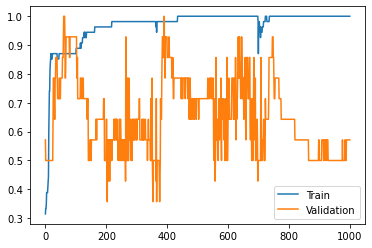

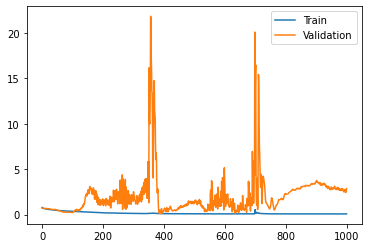

390 0.1073 0.9815 0.9813 0.1075 1.0000 1.0000


In [55]:

input_shape = all_data_co.iloc[:, 2:].shape[1]
hidden_size = 30
learning_rate = 0.0010


all_logits = []
g=G_dgl_co
torch.manual_seed(42)
net = GCN(input_shape, hidden_size, 2, weight=torch.double)
g = dgl.add_self_loop(g)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.01) #weight_Decay: l2 penalty
f1 = F1Score(task="multiclass", num_classes=2, average="weighted")
n_epochs = 1000
probability_train=[]
probability_val=[]
probability_test=[]
prediction_train=[]
prediction_val=[]
prediction_test=[]
train_acc=[]
train_loss=[]
train_f1=[]
val_loss=[]
val_acc=[]
val_f1=[]
score=[]
for epoch in range(n_epochs):
    net.train()
    g_train=g.subgraph(train_indices)
    g_train.ndata['label']=node_labels[train_indices]
    if 'weight' in g_train.edata.keys():
        edge_weight = g_train.edata['weight'].double().float()
    else:
        edge_weight = None

    logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
    # save the logits for visualization later
    logp_train = F.log_softmax(logits_train, 1)
    probs_train=torch.exp(logp_train)
    prob_train,predicted_train=torch.max(probs_train, 1)
    probability_train.append(prob_train)
    prediction_train.append(predicted_train)
    loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([0.045,0.021])) 
    train_loss.append(loss)
    correct = (predicted_train == node_labels[train_indices]).sum().item()
    accuracy = correct / len(train_indices)
    train_acc.append(accuracy)
    f1_score=f1(predicted_train,node_labels[train_indices])
    train_f1.append(f1_score)

    net.eval()
    g_val=g.subgraph(val_indices)
    if 'weight' in g_val.edata.keys():
        edge_weight = g_val.edata['weight'].double().float()
    else:
        edge_weight = None
    logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
    logp_val = F.log_softmax(logits_val, 1)
    probs_val=torch.exp(logp_val)
    prob_val,predicted_val=torch.max(probs_val, 1)
    probability_val.append(prob_val)
    prediction_val.append(predicted_val)
    loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
    val_loss.append(loss_val)
    val_correct = (predicted_val == node_labels[val_indices]).sum().item()
    val_accuracy = val_correct / len(val_indices)
    val_acc.append(val_accuracy)
    f1_score_val=f1(predicted_val,node_labels[val_indices])
    val_f1.append(f1_score_val)

    # test part
    g_test=g.subgraph(test_indices)
    if 'weight' in g_test.edata.keys():
        edge_weight = g_test.edata['weight'].double().float()
    else:
        edge_weight = None
    logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
    logp_test = F.log_softmax(logits_test, 1)
    probs_test=torch.exp(logp_test)
    prob_test,predicted_test=torch.max(probs_test, 1)
    probability_test.append(prob_test)
    prediction_test.append(predicted_test)
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

plt.plot(range(0, n_epochs), [acc for acc in train_acc], label="Train")
plt.plot(range(0, n_epochs), [acc for acc in val_acc], label="Validation")
plt.legend()
plt.show()

plt.plot(range(0, n_epochs), [loss.item() for loss in train_loss], label="Train")
plt.plot(range(0, n_epochs), [loss.item() for loss in val_loss], label="Validation")
plt.legend()
plt.show()

min_unl_loss = np.argmin([i.item() for i in val_loss])

print(min_unl_loss,"%.4f" %train_loss[min_unl_loss].item(),"%.4f" %train_acc[min_unl_loss],
                   "%.4f" %train_f1[min_unl_loss].item(),"%.4f" %val_loss[min_unl_loss].item(),
                   "%.4f" %val_acc[min_unl_loss],"%.4f" %val_f1[min_unl_loss].item())

predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
predicted_df=pd.merge(all_data_co, predicted_labels, left_index=True, right_index=True,
                           how="inner")[['GeneName','prediction','probability']]
predicted_df['probability']=predicted_df['probability'].apply(lambda x: round(x, 2))
VPS13D=predicted_df[predicted_df['GeneName']=='VPS13D'][['prediction','probability']].values[0]    
UFM1=predicted_df[predicted_df['GeneName']=='UFM1'][['prediction','probability']].values[0]
C1QBP=predicted_df[predicted_df['GeneName']=='C1QBP'][['prediction','probability']].values[0]

pred_counts = predicted_df[predicted_df['probability']>0.95]['prediction'].value_counts()

if 1 in pred_counts.index:
    patho_genes = pred_counts[1]
else:
    patho_genes = 0



In [56]:
VPS13D

array([1. , 0.6])

In [57]:
UFM1

array([0.  , 0.56])

In [58]:
C1QBP

array([1.  , 0.65])

In [59]:
patho_genes

91

In [60]:
predicted_labels_train=pd.DataFrame({'prediction':[i.item() for i in prediction_train[min_unl_loss]],'probability':[i.item() for i in probability_train[min_unl_loss]]}).set_index(train_indices)
predicted_df_train=pd.merge(all_data_co, predicted_labels_train, left_index=True, right_index=True,
                               how="inner")[['GeneName','prediction','probability','pathogenic']]
len(predicted_df_train)

54

#### Visualizing the network

In [61]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [62]:
predicted_genes_all=pd.concat([predicted_df_train,predicted_df],axis=0).sort_index()
predicted_genes_all

,GeneName,prediction,probability,pathogenic
0,LAP3,0,0.60,NaN
1,SLC25A5,1,0.55,NaN
2,ACSM3,1,0.74,NaN
3,TNFRSF12A,1,0.54,NaN
4,ALDH3B1,0,0.86,NaN
...,...,...,...,...
1288,LA16c-380F5.3,1,0.53,NaN
1289,ERICD,1,0.70,NaN
1290,CH17-172B3.1,1,0.53,NaN
1291,LLNLR-263F3.1,0,0.78,NaN


In [63]:
# Identify the connected components
components = list(nx.connected_components(G_co))

# Find the largest component (main set of network groups)
largest_component = max(components, key=len)

# Create a subgraph with only the nodes in the largest component
filtered_graph = G_co.subgraph(largest_component)

1


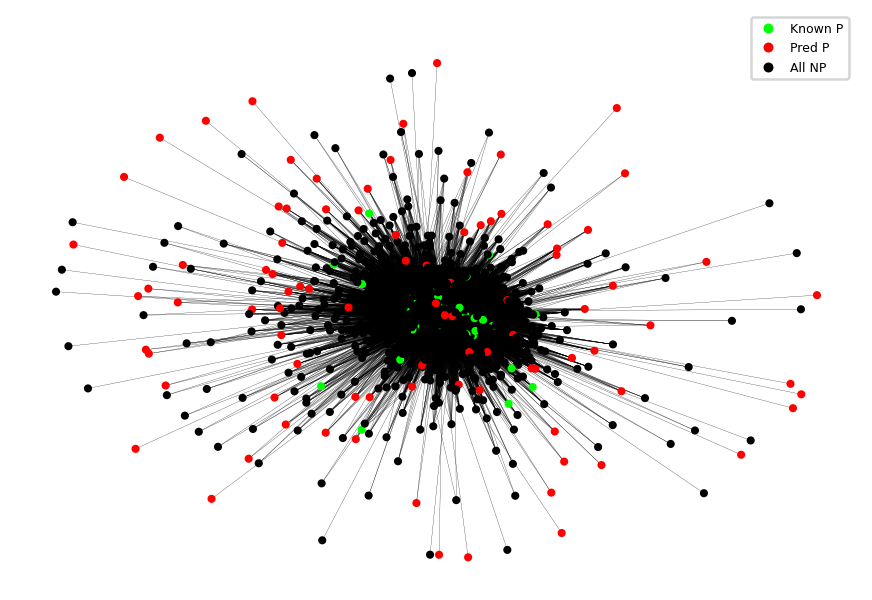

In [64]:

def draw(frame):
    colors = []
    for v in filtered_graph.nodes:
        
        if predicted_genes_all['pathogenic'][v]=='1':
            colors.append("#00FF00")
        elif predicted_genes_all['pathogenic'][v]=='0':
            colors.append("#000000")
        elif predicted_genes_all['prediction'][v]==1 and predicted_genes_all['probability'][v]>0.95:
            colors.append("#FF0000")
        else:
            colors.append("#000000")
    ax.cla()
    ax.axis('off')
    p=nx.spring_layout(filtered_graph.to_undirected())
    nx.draw_networkx(filtered_graph.to_undirected(), p, node_color=colors,
            with_labels=False, node_size=5, ax=ax, width=0.1)
   # nx.draw_networkx_labels(G_draw.to_undirected(), p, labels=node_labels, font_size=6, font_color='black')
    legend_labels = {
        'Known P': "#00FF00",
        'Pred P':"#FF0000",
        'All NP':"#000000"
    }
    
    # Display the legend
    for label, color in legend_labels.items():
        ax.plot([], [], marker='o', color='w', markerfacecolor=color, label=label, markersize=5)
    ax.legend(loc='upper right',fontsize=5,bbox_to_anchor=(1, 1.05))
    print(frame)
fig = plt.figure(dpi=180)
fig.clf()
ax = fig.subplots()
draw(1)

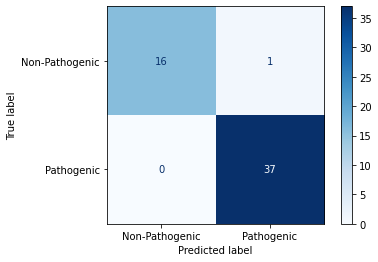

In [66]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report

cm=confusion_matrix(node_labels[train_indices],prediction_train[min_unl_loss])
disp = ConfusionMatrixDisplay(cm,display_labels=['Non-Pathogenic', 'Pathogenic']) #display_labels=['Class 0', 'Class 1']
disp.plot(cmap=plt.cm.Blues)

In [68]:
print(classification_report(node_labels[train_indices],prediction_train[min_unl_loss]))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.97      1.00      0.99        37

    accuracy                           0.98        54
   macro avg       0.99      0.97      0.98        54
weighted avg       0.98      0.98      0.98        54



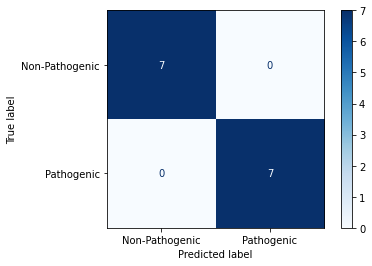

In [69]:
cm=confusion_matrix(node_labels[val_indices],prediction_val[min_unl_loss])
disp = ConfusionMatrixDisplay(cm,display_labels=['Non-Pathogenic', 'Pathogenic']) #display_labels=['Class 0', 'Class 1']
disp.plot(cmap=plt.cm.Blues)

In [70]:
print(classification_report(node_labels[val_indices],prediction_val[min_unl_loss]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

